이 실습은 [링크](https://github.com/ashrefm/multi-label-soft-f1/blob/master/Multi-Label%20Image%20Classification%20in%20TensorFlow%202.0.ipynb)의 자료를 참고하여 구성하였습니다.


필요한 라이브러리를 import해줍니다.

In [1]:
!wget -O utils.py https://raw.githubusercontent.com/ashrefm/multi-label-soft-f1/master/utils.py
from utils import *

import os
import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub 
from keras.preprocessing import image 
from tensorflow.keras.layers import Dense, Dropout

--2021-04-24 11:07:27--  https://raw.githubusercontent.com/ashrefm/multi-label-soft-f1/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11780 (12K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  11.50K  --.-KB/s    in 0.001s  

2021-04-24 11:07:27 (17.0 MB/s) - ‘utils.py’ saved [11780/11780]



데이터를 다운로드하고 결측값이 있는 행을 없애 정제합니다.

데이터에는 영화 ID, 링크, 제목, 평점, 장르(multi-label), 영화포스터의 링크 컬럼이 있습니다.

In [2]:
!wget -O movie.csv https://raw.githubusercontent.com/ashrefm/multi-label-soft-f1/master/data/movie_poster/MovieGenre.csv

movies = pd.read_csv("./movie.csv", encoding="ISO-8859-1")
movies.dropna(subset=['imdbId', 'Genre', 'Poster'], inplace=True) 
movies = movies[:10000]
movies.head(3)

--2021-04-24 11:07:29--  https://raw.githubusercontent.com/ashrefm/multi-label-soft-f1/master/data/movie_poster/MovieGenre.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9128209 (8.7M) [text/plain]
Saving to: ‘movie.csv’

movie.csv           100%[===================>]   8.71M  --.-KB/s    in 0.1s    

2021-04-24 11:07:30 (65.0 MB/s) - ‘movie.csv’ saved [9128209/9128209]



,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...


영화 포스터 데이터를 다운로드합니다.

다운로드에 약 3분정도의 시간이 소요됩니다. 

Errors로 표시된 수는 영화 포스터를 찾을 수 없어 다운로드하지 못한 경우입니다.

In [3]:
download_dir = './data/movie_poster/images' 
movies = download_parallel(movies, download_dir)  

Created new directory './data/movie_poster/images'

Downloading...

Download in parallel mode took 219 seconds.
Success: 8970
Errors: 1030


장르당 영화가 많지 않은 경우는 제외하고 학습하도록 합니다.

장르 빈도를 세보고, 장르당 1000건 미만의 영화가 있는 경우는 제외하겠습니다

In [4]:
label_freq = movies['Genre'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)
rare = list(label_freq[label_freq<1000].index)
movies['Genre'] = movies['Genre'].apply(lambda s: [l for l in str(s).split('|') if l not in rare]) 

데이터를 train과 val로 쪼갭니다 (약 9:1)

In [5]:
X_train, X_val = movies['imdbId'][:8000], movies['imdbId'][8000:]
y_train, y_val = movies['Genre'][:8000], movies['Genre'][8000:]
X_train = [os.path.join('./data/movie_poster/images', str(f)+'.jpg') for f in X_train]
X_val = [os.path.join('./data/movie_poster/images', str(f)+'.jpg') for f in X_val] 
y_train = list(y_train)
y_val = list(y_val) 

아래와 같은 데이터가 있습니다.

하나의 영화는 한 개 이상의 장르를 갖습니다

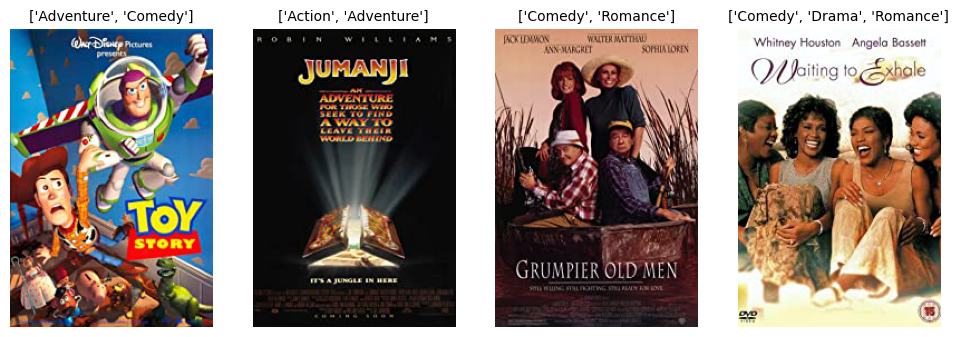

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

style.use("default")
plt.figure(figsize=(12,4))
for i in range(4):
    ax = plt.subplot(1, 4, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')


장르는 다음과 같이 총 7가지가 있습니다. 

영화 장르에 따라 멀티라벨 벡터로 바꿔줍니다.

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(y_train)

N_LABELS = len(mlb.classes_)
print("장르 :")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))
print()

y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)
print(">> label to label vector")
for i in range(3):
    print("LABEL : ", y_train[i],", LABEL VECTOR : ", y_train_bin[i])

장르 :
0. Action
1. Adventure
2. Comedy
3. Crime
4. Drama
5. Romance
6. Thriller

>> label to label vector
LABEL :  ['Adventure', 'Comedy'] , LABEL VECTOR :  [0 1 1 0 0 0 0]
LABEL :  ['Action', 'Adventure'] , LABEL VECTOR :  [1 1 0 0 0 0 0]
LABEL :  ['Comedy', 'Romance'] , LABEL VECTOR :  [0 0 1 0 0 1 0]


하이퍼파라미터를 설정합니다

In [8]:
IMG_SIZE = 224  
CHANNELS = 3 
BATCH_SIZE = 256  
LR = 0.0001 
EPOCHS = 30

데이터셋을 일괄 동일한 사이즈로 맞추고, 픽셀값을 보정합니다

In [9]:
def parse_function(filename, label): 
    image_string = tf.io.read_file(filename) 
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS) 
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE]) 
    image_normalized = image_resized / 255.0
    return image_normalized, label
    
def create_dataset(filenames, labels):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels)) 
    dataset = dataset.map(parse_function) 
    dataset = dataset.batch(BATCH_SIZE)  
    return dataset

train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

MobileNetv2의 feature extractor를 가져와 적용하고, 새로운 레이어를 추가합니다.

다중 라벨 분류를 수행하기 위해 output layer는 sigmoid 뉴런으로 설정합니다

regularization을 위해 dropout도 추가합니다


In [10]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

model = tf.keras.Sequential([
    hub.KerasLayer(feature_extractor_url, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(N_LABELS, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 2,422,855
Trainable params: 164,871
Non-trainable params: 2,257,984
_________________________________________________________________


컴파일하고 학습을 진행합니다.

오버피팅을 막기 위해 early stopping도 적용해봅니다.

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse')
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[es])

Epoch 1/30
32/32 [==============================] - 50s 519ms/step - loss: 0.2752 - val_loss: 0.1657
Epoch 2/30
32/32 [==============================] - 16s 497ms/step - loss: 0.1874 - val_loss: 0.1606
Epoch 3/30
32/32 [==============================] - 16s 498ms/step - loss: 0.1814 - val_loss: 0.1561
Epoch 4/30
32/32 [==============================] - 16s 496ms/step - loss: 0.1761 - val_loss: 0.1535
Epoch 5/30
32/32 [==============================] - 16s 496ms/step - loss: 0.1717 - val_loss: 0.1516
Epoch 6/30
32/32 [==============================] - 16s 497ms/step - loss: 0.1695 - val_loss: 0.1500
Epoch 7/30
32/32 [==============================] - 16s 502ms/step - loss: 0.1651 - val_loss: 0.1490
Epoch 8/30
32/32 [==============================] - 16s 498ms/step - loss: 0.1650 - val_loss: 0.1479
Epoch 9/30
32/32 [==============================] - 16s 498ms/step - loss: 0.1628 - val_loss: 0.1471
Epoch 10/30
32/32 [==============================] - 16s 499ms/step - loss: 0.1613 - val_lo

학습이 잘 되었는지 러닝커브를 확인합니다

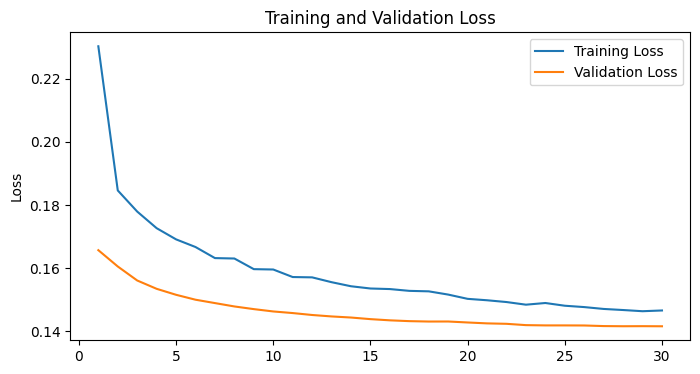

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss'] 
epochs = len(loss) 
plt.figure(figsize=(8, 4))

plt.plot(range(1, epochs+1), loss, label='Training Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.show() 

인터넷에서 원하는 영화 포스터를 찾고, 이미지 주소를 복사하여 추론해봅시다

In [87]:
def inference(img_path, model): 
    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values 
    if len(prediction)==0:
      prediction = [mlb.classes_[tf.argmax(model.predict(img)[0])]]

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('Prediction\n{}\n'.format(list(prediction)), fontsize=12)
    plt.show()

--2021-04-24 12:04:46--  https://blog.kakaocdn.net/dn/pa2Z1/btqFHa2SWQ4/PrK15Q4kDNT7KmoWX6iJWK/img.jpg
Resolving blog.kakaocdn.net (blog.kakaocdn.net)... 110.76.142.63
Connecting to blog.kakaocdn.net (blog.kakaocdn.net)|110.76.142.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388643 (380K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 379.53K   781KB/s    in 0.5s    

2021-04-24 12:04:47 (781 KB/s) - ‘test.jpg’ saved [388643/388643]



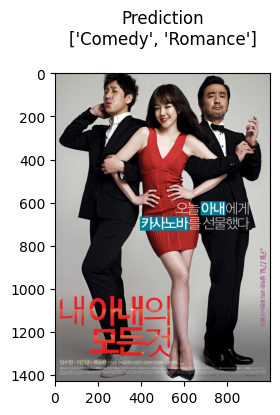

In [88]:
!wget -O test.jpg https://blog.kakaocdn.net/dn/pa2Z1/btqFHa2SWQ4/PrK15Q4kDNT7KmoWX6iJWK/img.jpg

inference("./test.jpg", model)


--2021-04-24 12:11:21--  https://www.themoviedb.org/t/p/w500/h18blchYYeoAfQHsEMGYUNbht0C.jpg
Resolving www.themoviedb.org (www.themoviedb.org)... 52.84.162.75, 52.84.162.122, 52.84.162.48, ...
Connecting to www.themoviedb.org (www.themoviedb.org)|52.84.162.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75656 (74K) [image/jpeg]
Saving to: ‘test2.jpg’

test2.jpg           100%[===================>]  73.88K  --.-KB/s    in 0.07s   

2021-04-24 12:11:21 (1.01 MB/s) - ‘test2.jpg’ saved [75656/75656]



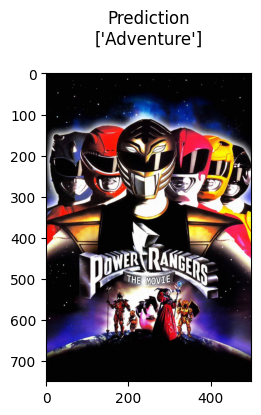

In [95]:
!wget -O test2.jpg https://www.themoviedb.org/t/p/w500/h18blchYYeoAfQHsEMGYUNbht0C.jpg

inference("./test2.jpg", model)
